In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examining the State and Action Spaces



In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Taking Random Actions in the Environment

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to the environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### Setting up the Agent



In [5]:
from agent_OneArm import Agent
agent = Agent(state_size, action_size, 1)

In case there is already a weight file available from previous training runs, then we can load it via this function call.

In [6]:
filename = 'checkpoint_OneArm.pth'
agent.load_weights(filename)

## Training

In case no agent weights have been loaded, we need to train our agent.

In [6]:
from collections import deque

def ddpg(n_episodes=300, max_t=1000):
    """DDPG for solving reacher environment.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # List containing scores from each episode
    scores_window = deque(maxlen=100)  # Last 100 scores
    solved = False                     # To keep track whether we already solved the environment

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # Reset the environment to train mode
        state = env_info.vector_observations[0]            # Get initial state
        score = 0                                          # Reset score

        for t in range(max_t): 
            action = agent.act(state)                      # Get action from actor
            action = np.clip(action, agent.action_limits[0], agent.action_limits[1]).numpy() # Clip it to valid range
            env_info = env.step(action)[brain_name]        # Send action to the environment
            next_state = env_info.vector_observations[0]   # Get the next state, ...
            reward = env_info.rewards[0]                   # ..., reward ...
            done = env_info.local_done[0]                  # ..., and whether the episode has finished 
            agent.step(state, action, reward, next_state, done)  # Take one step, learn new weights via soft update
            state = next_state                             # Progress states 
            score += reward                                # Update score

            if done: 
                break
        scores_window.append(score)                        # Save most recent score
        scores.append(score)                               # Save most recent score

        # display some progress
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode% 100 ==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= 30 and not solved:    # Only print "solved" if target score reached for the first time
            print("\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format
                 (i_episode - 100, np.mean(scores_window)))
            solved = True
            answer = input("Should I continue training? [Y/n]")  # Give the user the possibility to cancel further training
            if answer.lower()=='n':
                break
    return scores

# Train agent and keep track of the scores
if 'scores' in locals():
    # Append if scores already exist, adjust epsilon to final value
    scores += ddpg(n_episodes=100) 
else: 
    # No scores have been generated, so start training all over, again
    scores = ddpg()


Episode 100	Average Score: 2.08
Episode 200	Average Score: 22.87
Episode 224	Average Score: 30.18
Environment solved in 124 episodes!	Average Score: 30.18
Should I continue training? [Y/n]n


In [ ]:
filename = 'checkpoint_OneArm.pth'
agent.save(filename)

## Visualization of Results


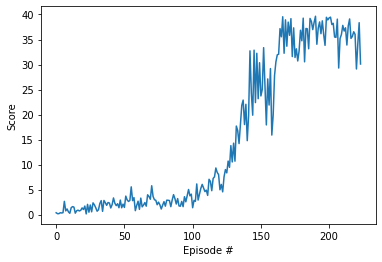

In [7]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Moving average of the results plot

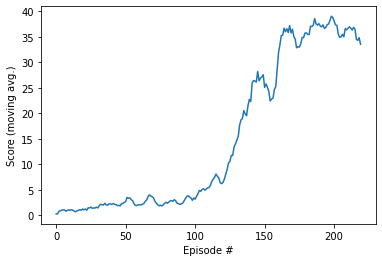

In [8]:
window = 5
cumsum, moving_avgs = [0], []

# Credits to Aikude (accessed 2020-04-08): 
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
for i, x in enumerate(scores, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=window:
        moving_avg = (cumsum[i] - cumsum[i-window])/window
        moving_avgs.append(moving_avg)
        
fig = plt.figure()
plt.plot(np.arange(len(moving_avgs)), moving_avgs)
plt.ylabel('Score (moving avg.)')
plt.xlabel('Episode #')
plt.show()

## Testing

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # Reset the environment to test mode
state = env_info.vector_observations[0]            # Get the current state
score = 0                                          # Initialize the score
while True:
    action = agent.act(state).numpy()                     # Select an action as suggested by the agent
    env_info = env.step(action)[brain_name]        # Send the action to the environment
    next_state = env_info.vector_observations[0]   # Get the next state
    reward = env_info.rewards[0]                   # Get the reward
    done = env_info.local_done[0]                  # See if episode has finished
    score += reward                                # Update the score
    state = next_state                             # Progress one step
    if done:                                       # Exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 39.46999911777675


In [10]:
env.close()